In [33]:
import requests
import pandas as pd
from geopy.geocoders import Nominatim
import pytz
from datetime import datetime
import numpy as np
from IPython.display import display, clear_output, Markdown


date = datetime(2018, 11, 1, 0, 0, 0, tzinfo=pytz.utc)
#places = ['Bottrop, DE']
places = ['Bottrop, DE', 'Vantaa, FI', 'Bologna, IT', 'Hasselt, BE', 'Surrey, UK']

devices_api = 'https://api.smartcitizen.me/v0/devices/'

In [34]:
def devices(place):

    geolocator = Nominatim(user_agent="iSCAPE")

    location = geolocator.geocode(place)

    location_str = str(location.latitude) + ',' + str(location.longitude)

    params = {'near': location_str, 'within': '10000'}

    req = requests.get(devices_api, params=params).json()
    
    # for item in req:
    #     print item
    devices = pd.DataFrame(req)
    devices['iscape_site'] = place
    devices['added_at'] = pd.to_datetime(devices['added_at'])
    devices['last_reading_at'] = pd.to_datetime(devices['last_reading_at'])
    devices = devices[devices['last_reading_at'] > date.isoformat()]
    devices = devices[devices['added_at'] > date.isoformat()]

    # Probably this could be done via list comprehension but it's clearer this way
    # The problem comes with the dict within the pandas series, that it's not directly indexable from pandas (same sintax)
    list_kits = list()
    for item in devices.kit:
        if item['id'] == 20: list_kits = devices[devices.kit == item].index
    
    # Filter devices
    devices = devices.loc[list_kits]
    
    devices['total_readings'] = devices.apply(lambda row: readings(row), axis=1)
    
    devices['total_readings_days'] = devices.apply(lambda row: row['total_readings'] / (60.0*24.0), axis = 1)
    devices['total_days_last_reading'] = devices.apply(lambda row: max(0, (row['last_reading_at'] - row['added_at']).days), axis=1)
    devices['total_days_since_registered'] = devices.apply(lambda row: (datetime.now() - row['added_at']).days, axis=1)

    devices['user_name'] = devices.apply(lambda row: row['owner']['username'], axis = 1)
    
    devices['ratio_readings_days'] = devices.apply(lambda row: ratio_days(row), axis = 1)
    devices['id'] = devices['id'].astype(str)
    return devices

def ratio_days(row):
    return row['total_readings_days'] / row['total_days_since_registered'] if row['total_days_since_registered'] else np.nan

def readings(row):

    params = {'from': date.isoformat(), 'to': datetime.now().isoformat(), 'rollup': '60s', 'sensor_id': 10 }

    req = requests.get(devices_api + str(row['id']) + '/readings', params=params).json()

    readings = req['readings']

    total_readings = len(readings)

    return total_readings

In [35]:
sites = []
for place in places:
    
    sites.append(devices(place))
    
sites = pd.concat(sites)
display(sites)   

,added_at,data,description,id,kit,last_reading_at,mac_address,name,owner,state,...,updated_at,user_tags,uuid,iscape_site,total_readings,total_readings_days,total_days_last_reading,total_days_since_registered,user_name,ratio_readings_days
0,2018-11-13 18:21:58,"{u'sensors': [{u'raw_value': 1623.83, u'uuid':...",iSCAPE Citizen Kit,5127,"{u'description': u'iSCAPE Citizen Kit ', u'upd...",2018-11-15 09:18:08,[FILTERED],Neighborly Crocodile Note,"{u'username': u'pascal.krueger', u'uuid': u'97...",has_published,...,2018-11-13T18:21:58Z,"[Inside, iSCAPE]",23346401-ab70-4ed8-b820-2bf52f6dd53b,"Bottrop, DE",17,0.011806,1,7,pascal.krueger,0.001687
1,2018-11-13 18:20:33,"{u'sensors': [{u'raw_value': 12.47, u'uuid': u...",iSCAPE Citizen Kit,5126,"{u'description': u'iSCAPE Citizen Kit ', u'upd...",2018-11-13 23:59:58,[FILTERED],Polaris,"{u'username': u'AlexChristian', u'uuid': u'd18...",has_published,...,2018-11-13T18:20:33Z,"[Inside, First Floor, iSCAPE]",d44e84fa-1fcc-4d2e-970b-9335bc7c05a6,"Bottrop, DE",210,0.145833,0,7,AlexChristian,0.020833
2,2018-11-13 18:19:44,"{u'sensors': [{u'raw_value': 119.44, u'uuid': ...",iSCAPE Citizen Kit,5125,"{u'description': u'iSCAPE Citizen Kit ', u'upd...",2018-11-13 18:28:04,[FILTERED],#Team Mia Carina,"{u'username': u'Carina Christian', u'uuid': u'...",has_published,...,2018-11-13T18:19:44Z,"[Inside, First Floor, iSCAPE]",d1e4a5ef-a100-4f4c-b753-93ef0d0d9b9c,"Bottrop, DE",17,0.011806,0,7,Carina Christian,0.001687
3,2018-11-13 18:29:41,"{u'sensors': [{u'raw_value': 107.21, u'uuid': ...",iSCAPE Citizen Kit,5128,"{u'description': u'iSCAPE Citizen Kit ', u'upd...",2018-11-13 17:31:51,[FILTERED],Bottrop Citizen Science - iSCAPE Team,"{u'username': u'iscape_TUDO_team', u'uuid': u'...",has_published,...,2018-11-14T15:21:56Z,"[Research, First Floor, Window, iSCAPE]",1eb51ac3-34e3-4eea-a5f0-8adb7623b20f,"Bottrop, DE",63,0.043750,0,7,iscape_TUDO_team,0.006250
4,2018-11-14 16:43:00,"{u'sensors': [{u'raw_value': 771.9, u'uuid': u...",iSCAPE Citizen Kit,5138,"{u'description': u'iSCAPE Citizen Kit ', u'upd...",2018-11-21 07:26:31,[FILTERED],Kit Cat,"{u'username': u'day1patch', u'uuid': u'5d719d7...",has_published,...,2018-11-14T16:43:00Z,"[Outside, Balcony, iSCAPE]",071981f4-4503-4eb1-b75c-32a05bd4a5e5,"Bottrop, DE",5146,3.573611,6,6,day1patch,0.595602
20,2018-11-16 06:33:45,"{u'sensors': [{u'raw_value': 3.6, u'uuid': u'a...",iSCAPE Citizen Kit,5170,"{u'description': u'iSCAPE Citizen Kit ', u'upd...",2018-11-16 15:07:51,[FILTERED],Yummy Anagram Anagram,"{u'username': u'OFI Gov', u'uuid': u'8bc3c336-...",has_published,...,2018-11-16T14:05:14Z,"[Experimental, Outside, Second Floor, Window, ...",793c592a-b07d-4015-89df-3f71498980bb,"Bottrop, DE",512,0.355556,0,5,OFI Gov,0.071111
22,2018-11-15 09:25:46,"{u'sensors': [{u'raw_value': 777.51, u'uuid': ...",iSCAPE Citizen Kit,5148,"{u'description': u'iSCAPE Citizen Kit ', u'upd...",2018-11-21 12:51:29,[FILTERED],PAKR-KAFO,"{u'username': u'pascal.krueger', u'uuid': u'97...",has_published,...,2018-11-15T09:25:46Z,"[Inside, Outside, Window, iSCAPE]",11b0e3b5-2b05-4264-a742-c060a8020972,"Bottrop, DE",4479,3.110417,6,6,pascal.krueger,0.518403
0,2018-11-12 16:42:55,"{u'sensors': [{u'raw_value': 25.64, u'uuid': u...",iSCAPE Citizen Kit,5101,"{u'description': u'iSCAPE Citizen Kit ', u'upd...",2018-11-21 12:51:03,[FILTERED],iscape_helsinki_07cf,"{u'username': u'arista', u'uuid': u'2a54eb58-7...",has_published,...,2018-11-12T16:42:55Z,"[Outside, Third Floor, Residential, iSCAPE]",b7bf9e8f-aaee-4c2b-86d2-b6d0686ae50a,"Vantaa, FI",9519,6.610417,8,8,arista,0.826302
2,2018-11-08 08:58:50,"{u'sensors': [{u'raw_value': 100.87, u'uuid': ...",iSCAPE Citizen Kit,5057,"{u'description': u'iSCAPE Citizen Kit ', u'upd...",2018-11-12 07:46:01,[FILTERED],80C9,"{u'username': u'Vantaa_AD', u'uuid': u'4412f1c...",has_published,...,2018-11-08T08:58:50Z,[iSCAPE],2a523950-72fd-49ef-81bd-f1d78b27e2c7,"Vantaa, FI",5685,3.947917,3,13,Vantaa_AD,0.303686
5,2018-11-10 15:43:15,"{u'sensors': [{u'raw_value': 73

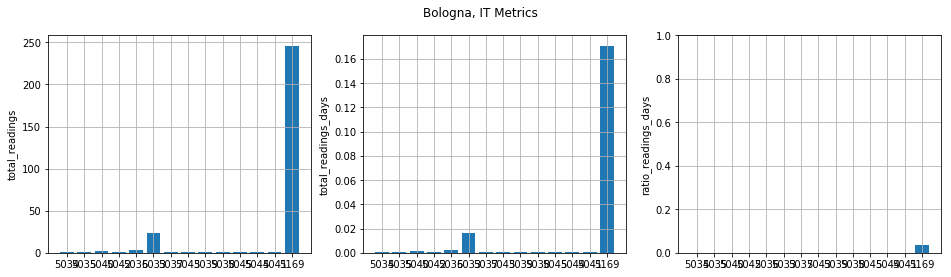

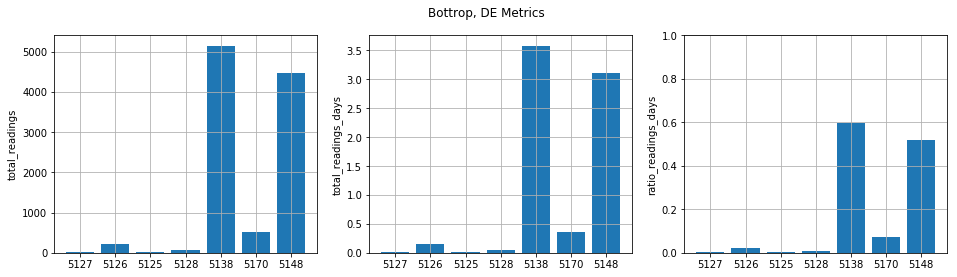

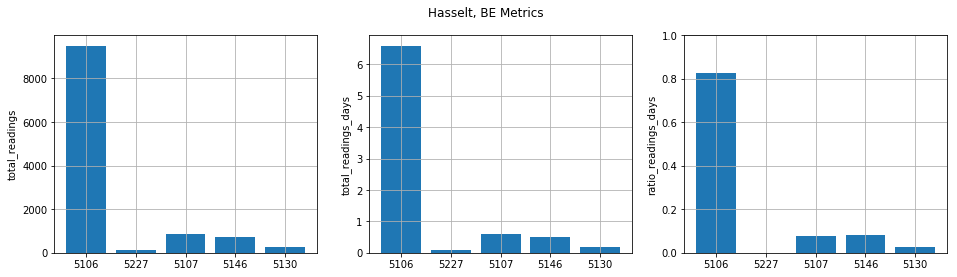

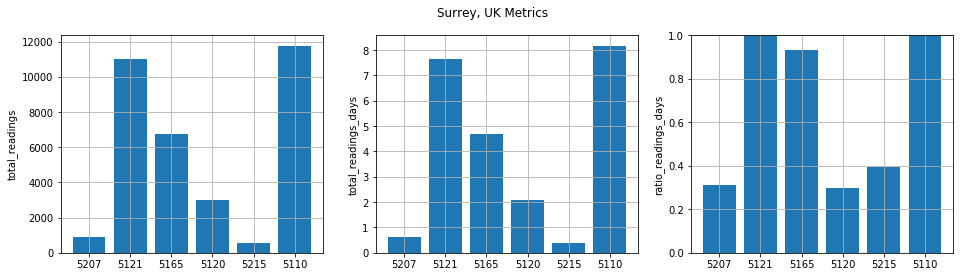

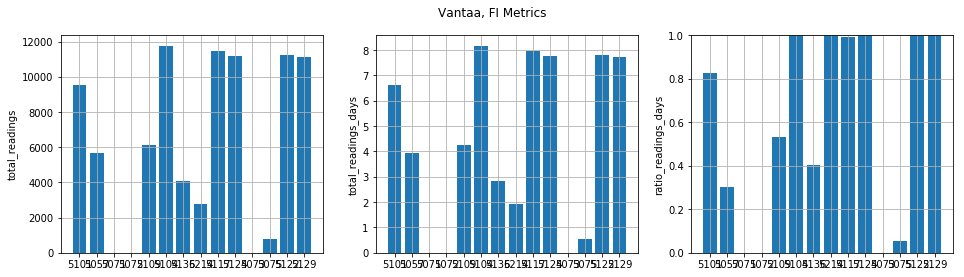

In [36]:
import matplotlib.pyplot as plot
% matplotlib inline

gg = [x for _, x in sites.groupby('iscape_site')]

for i in gg:
    i = i[['id', 'iscape_site', 'ratio_readings_days', 'total_readings', 'total_readings_days', 'total_days_last_reading', 'total_days_since_registered']]
    list_sites =  i['iscape_site'].values
    fig, axes = plot.subplots(1, 3, figsize = (16,4))
    axes[0].bar(i['id'], i ['total_readings'])
    axes[0].set_ylabel('total_readings')
    axes[0].grid(True)

    axes[1].bar(i['id'], i['total_readings_days'])
    axes[1].set_ylabel('total_readings_days')
    axes[1].grid(True)

    axes[2].bar(i['id'], i['ratio_readings_days'])
    axes[2].set_ylabel('ratio_readings_days')
    axes[2].set_ylim([0, 1])
    axes[2].grid(True)
    fig.suptitle(list_sites[0] + ' Metrics')
    

In [38]:

clean_sites = sites.drop(['data', 'description','added_at','last_reading_at','kit', 'total_days_since_registered', 'total_days_last_reading','mac_address', 'owner', 'state', 'system_tags', 'user_tags', 'uuid', 'updated_at' ], axis=1)  
    

clean_sites['ratio_readings_days'] = pd.Series(["{0:.2f}%".format(val * 100) for val in clean_sites['ratio_readings_days']], index = clean_sites.index)

    
#clean_sites = clean_sites.sort_values('total_readings')
    
    
clean_sites = clean_sites.sort_values(['iscape_site', 'total_readings'], ascending=[True, False])

clean_sites.index = clean_sites['id']

clean_sites = clean_sites[['iscape_site', 'name', 'user_name', 'ratio_readings_days', 'total_readings']]

display(clean_sites)   

,iscape_site,name,user_name,ratio_readings_days,total_readings
id,,,,,
5169,"Bologna, IT",BC60,Lui,3.42%,246
5033,"Bologna, IT",LLBologna,Erika84,0.10%,24
5036,"Bologna, IT",458A,Erika84,0.01%,3
5040,"Bologna, IT",FC19,Erika84,0.01%,2
5034,"Bologna, IT",090F,Erika84,0.00%,1
5035,"Bologna, IT",60BC,Erika84,0.00%,1
5042,"Bologna, IT",153E,Erika84,0.00%,1
5037,"Bologna, IT",458A,Erika84,0.00%,1
5043,"Bologna, IT",FDB7,Erika84,0.00%,1
